# 1 - Importing all the required modules and the functions.py file that contains our custom made functions

In [86]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob

import functions
import spectrogram_plotting_functions
import scipy.stats
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)


<module 'spectrogram_plotting_functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [87]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello sinha
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_nocontext_day2.mat',

# 3 Extracting band data around events and saving it in a dataframe

1.  The keyboard dict maps the keyboard codes that were the annotation in .mat files to their meanings. '98':'b' is the beginning of a black trial,'119':'w' is the beginning of a white trial,'120':'nc' is the beginning of a no context trial,'49':'1' signifies a correct dig by the rat,'48':'0' signifies an incorrect dig by the rat.
2. Then we initialize some empty dictionaries and dataframes to store data.
3. Then we start looping through each of the data files.
4. We first get the basename of the file using `os.path.basename(file)`
5. We split the basename using `os.path.splitext(base_name)` , and use  `functions.exp_params` to get the date of the task, rat id and the task the rat was doing

In [88]:

keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'} #specifying the map of keyboard annotations to their meanings.
all_bands={'total':[1,100],'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}

#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat', f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230626_dk6_BW_nocontext_day1.mat'] #This is just for testing purposes

#Initializing a few empty things to store data
events_codes_all = {}
compiled_data_all_epochs = []
compiled_data_list=[]
baseline_lfp_all = []
normalization_comparison_all = []
for file in files: #Looping through data files
    
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)
    date, mouse_id, task=functions.exp_params(base_name) #Using a custom made function [see functions.py]
    print(date, mouse_id, task)
    if task == 'nocontextday2' or task == 'nocontextos2':
        task = 'nocontext'
    if task =='nocontext':
        continue
    f=h5py.File(file, 'r')  ## Open the data file
    channels = list(f.keys()) ## Extract channels list from the data file
    print(channels)
    if not any("AON" in channel or "vHp" in channel for channel in channels):
        continue
    events,reference_electrode=functions.get_keyboard_and_ref_channels(f,channels)

    events_codes=np.array(events['codes'][0]) #saving the keyboard annotations of the events (door open, door close etc.)
    events_times=np.array(events['times'][0]) #saving when the events happened
    events_codes_all[base_name] = events_codes #saving the codes in a dictionary to be analyzed later for events other than the ones in our keyboard_dict map
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

    # task Start time
    first_event=events_times[0]
    #finding global start and end time of all channels, since they start and end recordings at different times
    global_start_time, global_end_time=functions.find_global_start_end_times(f,channels)
    
    ## Reference electrode finding and padding
    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()
    padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)


    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = 2000
            print(channel_id)
            print(raw_data.shape, raw_time.shape, sampling_rate)
            
            padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
            subtracted_data = padded_data - padd_ref_data
            raw_data=subtracted_data
            notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
            
            data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            first_event_index=np.where(raw_time>first_event)[0][0]

            baseline_row=[mouse_id,task,channel_id,[data_before], [functions.freq_band(data_before,12,30, sampling_rate)], [functions.freq_band(data_before,30,80, sampling_rate)], [functions.freq_band(data_before,4,12, sampling_rate)]]
            baseline_lfp_all.append(baseline_row)
            normalized_data=notch_filtered_data

            #Saving non-normalized data and normalized data for plotting
            normalization_row=[mouse_id,task,channel_id,[notch_filtered_data[first_event_index:first_event_index+30*sampling_rate]],np.mean(data_before),np.std(data_before),[normalized_data[first_event_index:first_event_index+30*sampling_rate]]]
            normalization_comparison_all.append(normalization_row)


            for i,epochi in enumerate(epochs):
                
                compiled_data = pd.DataFrame() # Initializing a dataframe to store the data of a single epoch

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                
                
                data_complete_trial=functions.extract_complete_trial_data(notch_filtered_data,time,door_timestamp,dig_timestamp,sampling_rate)
                data_trial_before, data_trial_after=functions.extract_door_data(notch_filtered_data,time,door_timestamp,sampling_rate)
                data_dig_before, data_dig_after=functions.extract_dig_data(notch_filtered_data,time,dig_timestamp,sampling_rate)
                epoch_data = [data_complete_trial, data_trial_before, data_trial_after, data_dig_before, data_dig_after]
                epoch_data = [functions.zscore_event_data(x, baseline_mean, baseline_std) for x in epoch_data]

                compiled_data = {
                    'rat': mouse_id,
                    'date': date,
                    'task': task,
                    'channel': channel_id,
                    'trial': i,
                    'timestamps': [door_timestamp, dig_timestamp],
                    'side': keyboard_dict[str(int(trial_type))],
                    'correct?': keyboard_dict[str(int(dig_type))],
                    'first 30 seconds power': functions.calculate_power_1D(data_before),
                    'time': time,
                    'complete_trial': epoch_data[0],
                    'pre_door': epoch_data[1],
                    'post_door': epoch_data[2],
                    'pre_dig': epoch_data[3],
                    'post_dig': epoch_data[4]
                }

                compiled_data_list.append(compiled_data)

compiled_data_all_epochs.extend(compiled_data_list)
compiled_data_all_epochs = pd.DataFrame(compiled_data_all_epochs)
compiled_data_all_epochs= compiled_data_all_epochs[compiled_data_all_epochs['task']!='nocontext']
baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'task', 'channel', 'data', 'beta', 'gamma', 'theta'])
normalization_comparison_all = pd.DataFrame(normalization_comparison_all, columns=['rat', 'task', 'channel', 'non_normalized_data', 'baseline_mean', 'baseline_std', 'normalized_data'])   


20230529 dk1 nocontext
20230529 dk3 nocontext
20230529 dk5 nocontext
20230529 dk6 nocontext
20230531 dk1 nocontextday2
20230531 dk3 nocontextday2
20230531 dk5 nocontextday2
20230531 dk6 nocontextday2
20230609 dk1 BWnocontext
['LFP1_vHp', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Memory', 'Ref', 'Respirat', 'file']
LFP1_vHp
(3960487,) (3960487,) 2000
notch filter applied
normalizing data
101.713685 98.0 115.92368499999999 48.0
333.79768499999994 98.0 338.87168499999996 49.0
444.175685 98.0 446.85367999999994 49.0
501.75368 98.0 504.30367999999993 49.0
760.9496849999999 119.0 762.7096849999999 49.0
860.7156849999999 119.0 862.9756849999999 49.0
950.9996849999999 119.0 954.8776899999999 49.0
1030.4496849999998 98.0 1032.059685 49.0
1118.8436849999998 98.0 1120.763685 49.0
1222.2376849999998 98.0 1224.1076799999998 49.0
1292.675685 98.0 1297.08369 48.0
1376.743685 119.0 1380.1036849999998 49.0
1467.2696799999999 119.0 1469.7196849999998 49.0
1533.645685 98.0 1536.311685 49.0
1603.7656849999998 

4.1 Now we will plot waveforms of different bands for between BWContext and BWNOcontext



C:\Users\sinha\AppData\Local\Temp\ipykernel_12516\594776578.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_data['channel']=rat_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')


KeyboardInterrupt: 

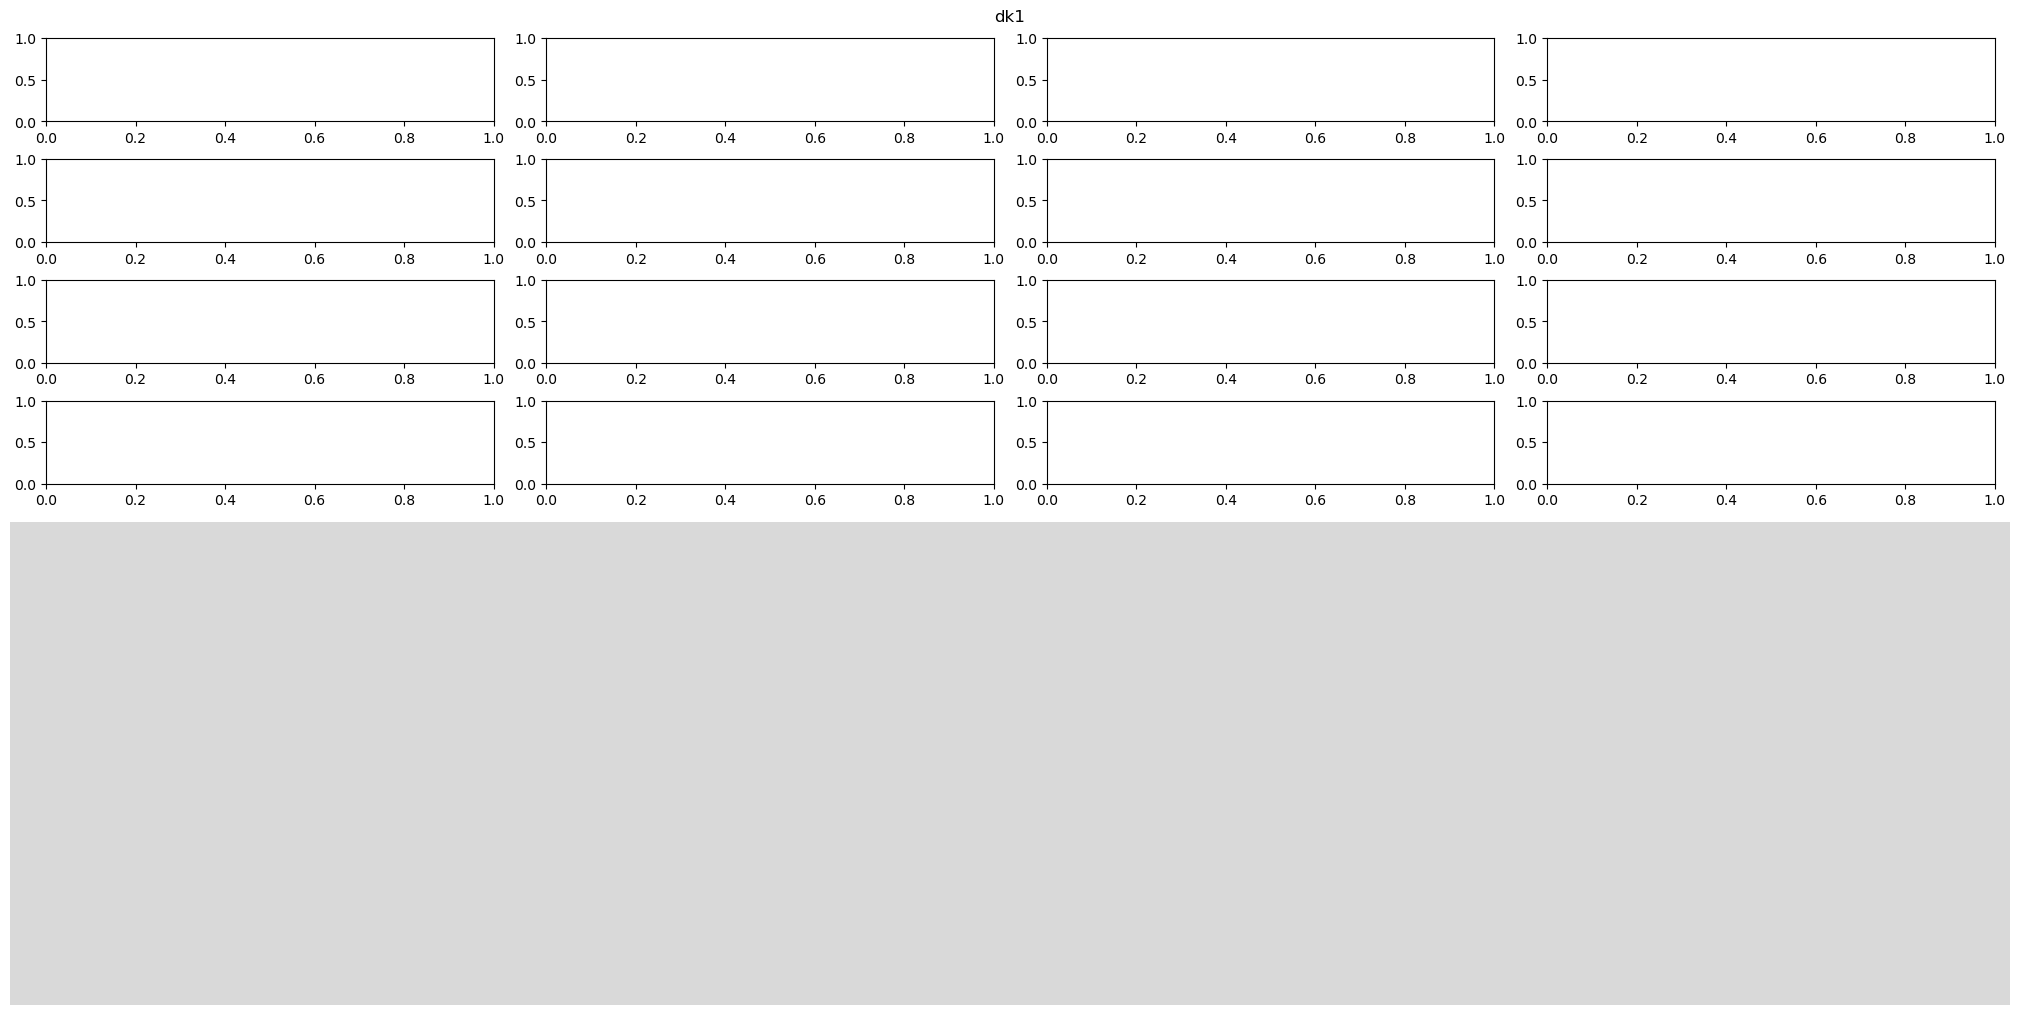

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window = [-2, 2]  # Set the window for the waveform

all_bands_dict = {'total':[1,100], 'beta':[12,20], 'gamma':[30,80], 'theta':[4,12]}
#band = 'total'  # Insert the band of interest
tasks = ['BWcontext', 'BWnocontext']
areas=['AON','vHp']
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

for rati in rat_list:
    rat_dict = {}
    rat_data = compiled_data_all_epochs[compiled_data_all_epochs['rat'] == rati]
    rat_data['channel']=rat_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    rat_data = rat_data.reset_index(drop=True)
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    subfigs[1].set_facecolor('0.85')
    fig.suptitle(f'{rati}')
    
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(4, 4)
        
        rat_data_area = rat_data[rat_data['channel'] == area]
        rat_data_area = rat_data_area.reset_index(drop=True)   
    
        for i, band in enumerate(all_bands_dict.keys()):
            rat_data_band=rat_data_area.__deepcopy__()
            for col in rat_data.columns[-5:]:
                rat_data_band[col] = rat_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

            rat_data_band_grouped = rat_data_band.groupby(['task', 'channel'])
            for (task, channel), group in rat_data_band_grouped:
                group=group.reset_index(drop=True)
                print(group.shape)
                for j, col in enumerate(group.columns[-4:]):
                    data = np.array(group[col])
                    data_mean = np.mean(data, axis=0)
                    data_sem = scipy.stats.sem(data, axis=0)
                    time_axis = np.linspace(0, 2, len(data_mean))
                    ax = axs[i, j]
                    ax.set_title(f'{band} {channel} {col}')
                    ax.plot(time_axis, data_mean, color=colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=colors[task])
    fig.savefig(os.path.join(savepath,f' LFP_waveform{rati}'), dpi=300)
    plt.show()
    plt.close(fig)

Now we will plot the power spectra for each rat and the mean power spectra

In [ ]:
power_df=compiled_data_all_epochs.__deepcopy__()
power_df.iloc[:,-5:]=power_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])
power_df['channel']=power_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')

C:\Users\sinha\AppData\Local\Temp\ipykernel_12516\3110437397.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  power_df.iloc[:,-5:]=power_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])


BWcontext AON
BWcontext vHp
BWnocontext AON
BWnocontext vHp
BWcontext AON
BWnocontext AON
BWnocontext vHp
BWcontext AON
BWcontext vHp
BWnocontext AON
BWnocontext vHp
BWcontext AON
BWcontext vHp
BWnocontext AON
BWnocontext vHp


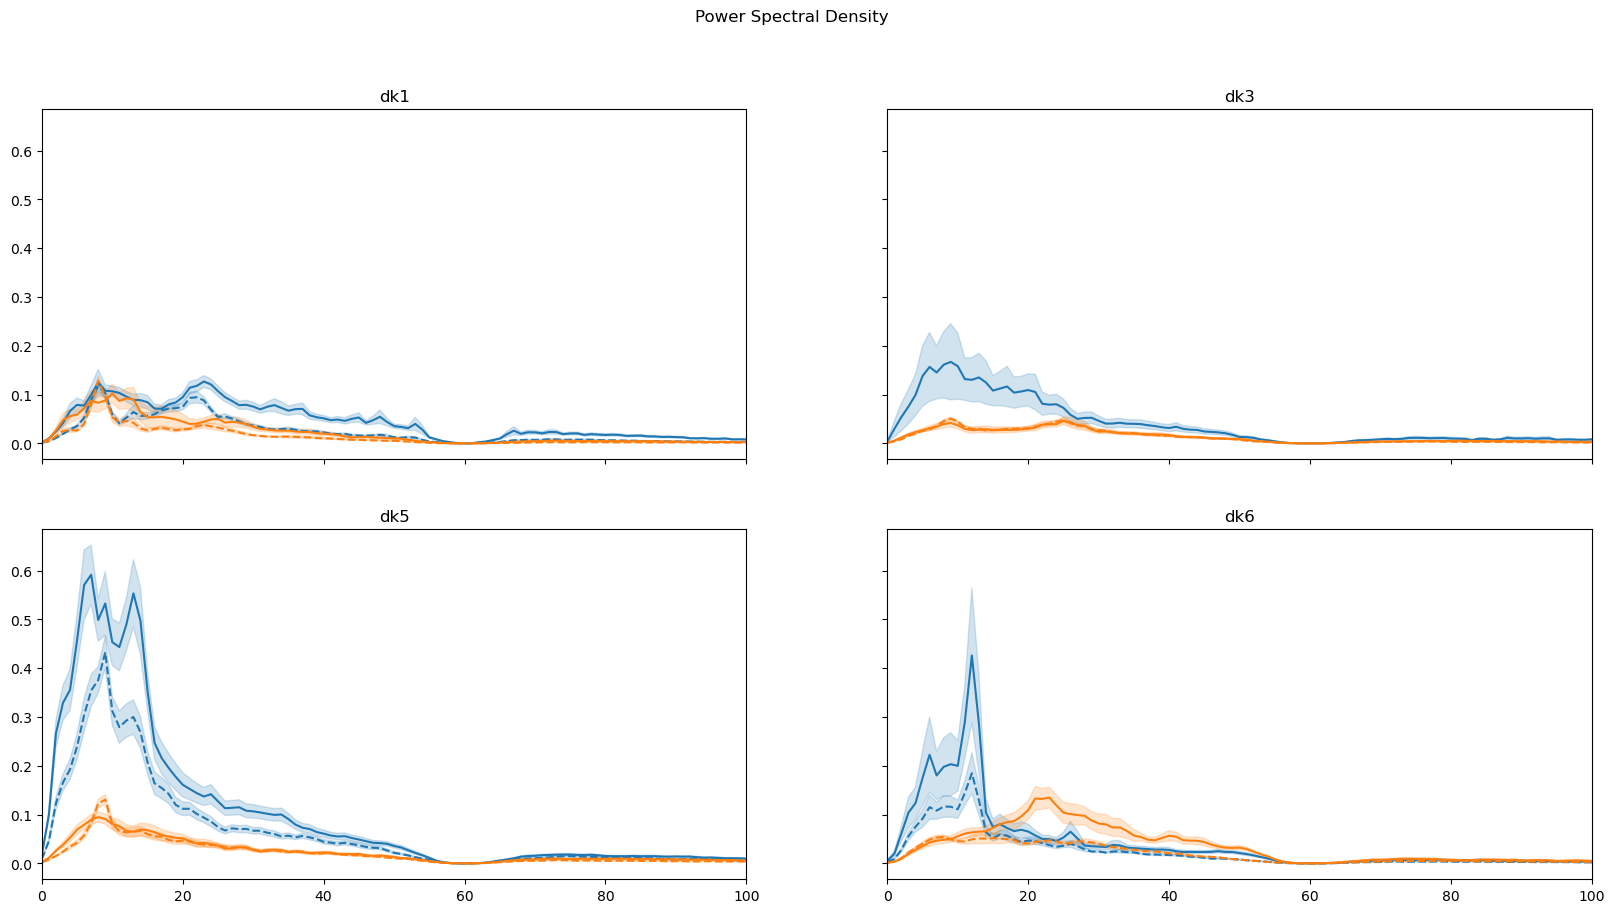

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs=axs.flatten()
fig.suptitle('Power Spectral Density')
linestyles = {'AON': '-', 'vHp': '--'}

for i,rati in enumerate(rat_list):
    rat_data=power_df[power_df['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    rat_data_grouped=rat_data.groupby(['task','channel'])
    for (task, channel),group in rat_data_grouped:
        print(task, channel)
        group=group.reset_index(drop=True)
        col='complete_trial'
        data = np.array(group[col])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        freq = np.linspace(0, 1000, len(data_mean))        
        ax = axs[i]
        ax.set_title(f'{rati}')
        ax.plot(freq, data_mean, color=colors[task], linestyle=linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=colors[task])
        ax.set_xlim(0, 100)

4.2 Average Power Spectra across all rats

4.3 Event Power Spectra individual Rats

4.4 Average event power spectra across all rats

4.5 Power Boxplots

In [93]:
import seaborn as sns

def get_band_power(data, band_start, band_end):
    freq_axs = np.linspace(0, 1000, len(data))
    band_data = data[(freq_axs >= band_start) & (freq_axs <= band_end)]
    power_sum = np.sum(band_data)
    freq_diff = freq_axs[1] - freq_axs[0]
    return power_sum * freq_diff

boxplot_df=compiled_data_all_epochs.__deepcopy__()
boxplot_df.iloc[:,-5:]=boxplot_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])


C:\Users\sinha\AppData\Local\Temp\ipykernel_12516\2752369245.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boxplot_df.iloc[:,-5:]=boxplot_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])


In [95]:

bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in boxplot_df.columns[-5:]:
    for band, (band_start, band_end) in bands_dict.items():
        boxplot_df[band + '_' + col] = boxplot_df[col].apply(lambda x: get_band_power(x, band_start, band_end))

events_list = ['pre_door', 'post_door', 'pre_dig', 'post_dig']
boxplot_df = boxplot_df.drop(columns=events_list)

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
fig.suptitle('Band Power')

for i, event in enumerate(events_list):
    if i >= len(axs):
        break
    event_cols = [col for col in boxplot_df.columns if event in col]
    event_df = boxplot_df[['rat', 'task', 'channel', *event_cols]]
    event_df = pd.melt(event_df, id_vars=['rat', 'task', 'channel'], var_name='band', value_name='power')
    event_df['band'] = event_df['band'].apply(lambda x: x.split('_')[0])
    ax=axs[i]
    sns.boxplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df,showfliers=False, ax=ax)
    sns.stripplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)

    axs[i].set_title(event)
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-3, 1e3)
    axs[i].set_ylabel('Power (uV^2)')



TypeError: object of type 'float' has no len()